In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

delta_t = 5
beta = 0.1  
k = 1 
lambda_ = 0.1  

M=40
m=4
num_trajectories=40
s_0_values = np.linspace(-np.pi, np.pi, num_trajectories)
# numerical data
def s(j, delta_t, s_0):
    Delta = 1e-4  
    t_max = j * delta_t  
    num_steps = int(t_max / Delta)  
    s = s_0  
    for _ in range(num_steps):
        s += Delta * lambda_ * np.sin(s) ** 2  # Update s
    return s

   
# Reward function
def reward_function(s):
    reward = beta * np.cos(k * s) ** 3 - lambda_ * np.sin(s)**2 * (-3 * k * np.cos(k * s)**2 * np.sin(k * s))
    return reward
    
    
# Define periodic bases
def bases(s):
    bases=[1/np.sqrt(2*np.pi)]
    for m in range(1,M+1):
        bases.append(np.cos(m*s)/np.sqrt(np.pi))
        bases.append(np.sin(m*s)/np.sqrt(np.pi))
    return np.array(bases).reshape(-1,1)   #return column vector

def gradient_bases(s):
    gradient_bases=[0]
    for m in range(1,M+1):
        gradient_bases.append(-m*np.sin(m*s)/np.sqrt(np.pi))
        gradient_bases.append(m*np.cos(m*s)/np.sqrt(np.pi))
    return np.array(gradient_bases).reshape(-1,1)  

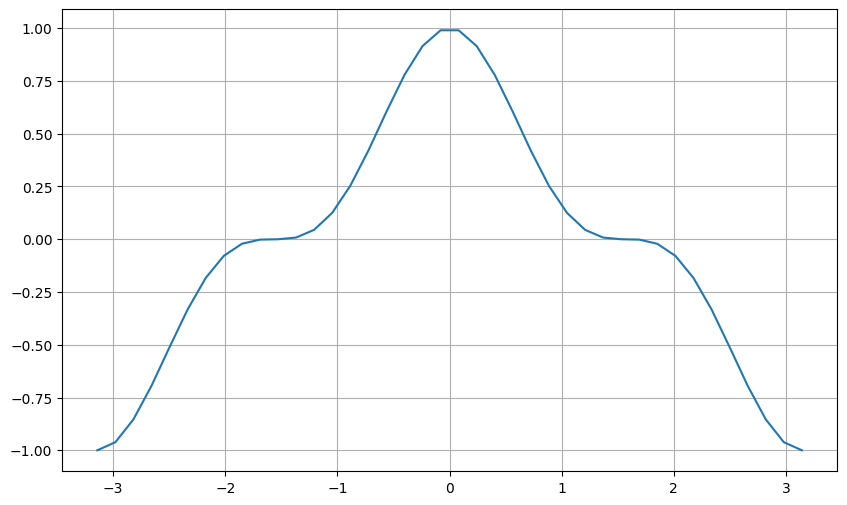

In [34]:
# True Value function

True_values = np.cos(k*s_0_values)**3

plt.figure(figsize=(10, 6))
plt.plot(s_0_values, True_values)
plt.grid()
plt.show()

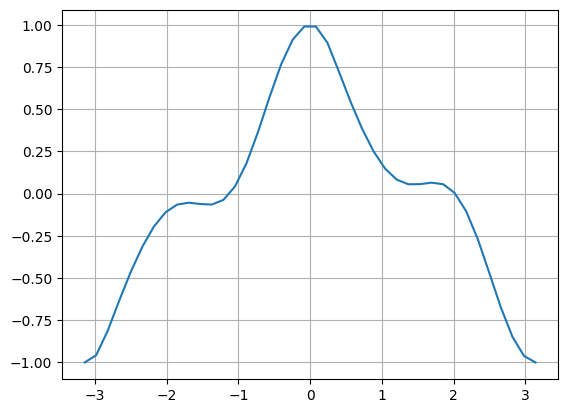

In [35]:
#solution to 1-st order PhiBE
def mu_1(j,s_0):
    return (s(1,delta_t,s(j,delta_t,s_0))-s(j,delta_t,s_0) )/ delta_t

A = np.zeros((2 * M + 1, 2 * M + 1))  
b = np.zeros((2 * M + 1,1))  


PhiBE_1st_values = []

for s_0 in s_0_values:
    for j in range(0, m):
        Phi = bases(s(j,delta_t,s_0))
        A += np.outer(Phi, beta * Phi.T - mu_1(j,s_0) * gradient_bases(s(j,delta_t,s_0)).T)
        r = reward_function(s(j,delta_t,s_0))
        b += r * Phi
        
theta = np.linalg.solve(A, b)   
for s_0 in s_0_values:
    a = theta.T @ bases(s_0)
    PhiBE_1st_values.append(a.item())

plt.plot(s_0_values, PhiBE_1st_values)
plt.grid()
plt.show()

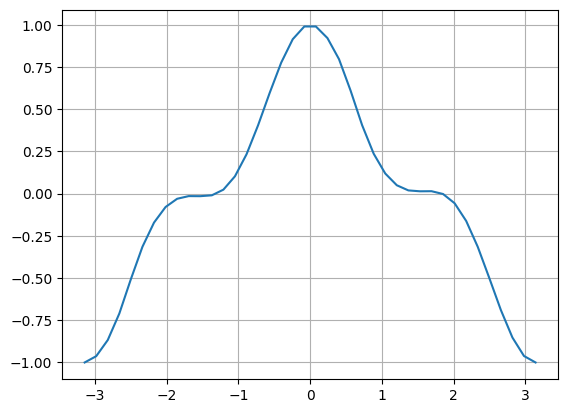

In [36]:
#solution to 2-nd order PhiBE
def mu_2(j,s_0):
    return 2*(s(1,delta_t,s(j,delta_t,s_0))-s(j,delta_t,s_0) )/ delta_t - (s(2,delta_t,s(j,delta_t,s_0))-s(j,delta_t,s_0) ) / (2 *delta_t)

A2 = np.zeros((2 * M + 1, 2 * M + 1))  
b2 = np.zeros((2 * M + 1,1)) 


PhiBE_2nd_values = []

for s_0 in s_0_values:
    for j in range(0, m-1):
        Phi = bases(s(j,delta_t,s_0))
        A2 += np.outer(Phi, beta * Phi.T - mu_2(j,s_0) * gradient_bases(s(j,delta_t,s_0)).T)
        r = reward_function(s(j,delta_t,s_0))
        b2 += r * Phi
        
theta = np.linalg.solve(A2, b2) 
for s_0 in s_0_values:
    V_Galerkin = theta.T @ bases(s_0)
    PhiBE_2nd_values.append(V_Galerkin.item())

plt.plot(s_0_values, PhiBE_2nd_values)
plt.grid()
plt.show()

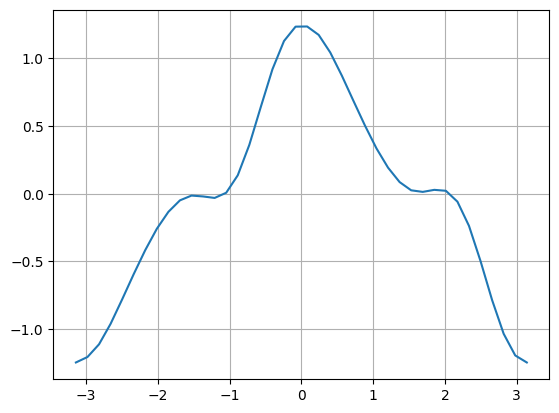

In [45]:
#solution to BE
def Sol_BE(s_0):
    V = 0  
    for j in range(0,8):
        V += np.exp(-beta*j*delta_t)*reward_function(s(j,delta_t,s_0)) * delta_t
    return V


BE_values = np.array([Sol_BE(s) for s in s_0_values])


plt.plot(s_0_values,BE_values)
plt.grid()
plt.show()

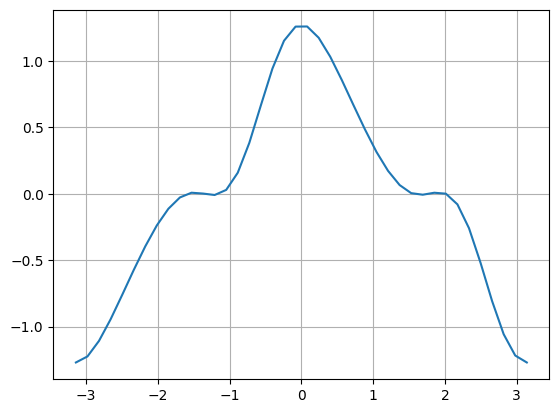

In [37]:
#LSTD to BE
A3 = np.zeros((2 * M + 1, 2 * M + 1))  # 矩阵 A
b3 = np.zeros((2 * M + 1,1))  # 向量 b


LSTD_values = []

for s_0 in s_0_values:
    for j in range(0, m-1):
        Phi = bases(s(j,delta_t,s_0))
        A3 += np.outer(Phi, Phi.T - np.exp(-beta*delta_t) * bases(s(j+1,delta_t,s_0)).T)
        r = reward_function(s(j,delta_t,s_0))*delta_t
        b3 += r * Phi
        
theta = np.linalg.solve(A3, b3)   
for s_0 in s_0_values:
    V_LSTD = theta.T @ bases(s_0)
    LSTD_values.append(V_LSTD.item())

plt.plot(s_0_values,LSTD_values)
plt.grid()
plt.show()

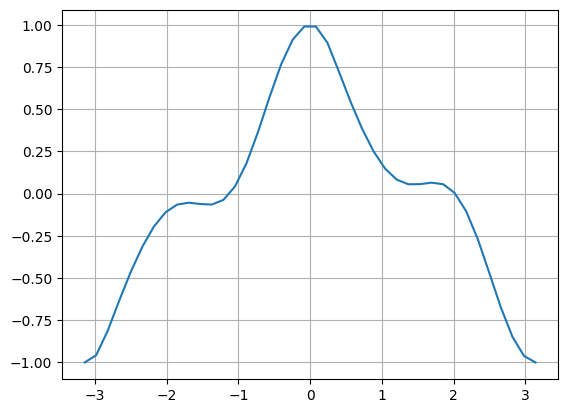

In [38]:
#Algorithm 1 for 1-st order PhiBE 
def mu_1_al(j,s_0):
    return (s(j + 1,delta_t,s_0) - s(j,delta_t,s_0)) / delta_t

A4 = np.zeros((2 * M + 1, 2 * M + 1))  # 矩阵 A
b4 = np.zeros((2 * M + 1,1))  # 向量 b

Galerkin_1st_values = []

for s_0 in s_0_values:
    for j in range(0, m):
        Phi = bases(s(j,delta_t,s_0))
        A4 += np.outer(Phi, beta * Phi.T - mu_1_al(j,s_0) * gradient_bases(s(j,delta_t,s_0)).T)
        r = reward_function(s(j,delta_t,s_0))
        b4 += r * Phi
        
theta = np.linalg.solve(A4, b4)   
for s_0 in s_0_values:
    V_Galerkin = theta.T @ bases(s_0)
    Galerkin_1st_values.append(V_Galerkin.item())

plt.plot(s_0_values,Galerkin_1st_values)
plt.grid(True)
plt.show()

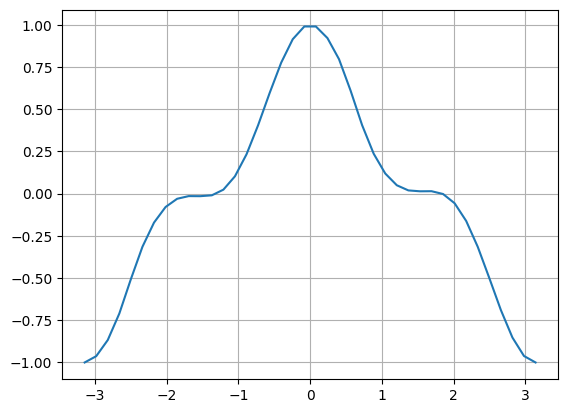

In [39]:
# Algorithm 1 to 2-nd order PhiBE (ntb)
def mu_2_al(j,s_0):
    return 2*(s(j + 1,delta_t,s_0) - s(j,delta_t,s_0))/delta_t - (s(j + 2,delta_t,s_0) - s(j,delta_t,s_0)) / (2 *delta_t)

A5 = np.zeros((2 * M + 1, 2 * M + 1))  # 矩阵 A
b5 = np.zeros((2 * M + 1,1))  # 向量 b


Galerkin_2nd_values = []

for s_0 in s_0_values:
    for j in range(0, m-1):
        Phi = bases(s(j,delta_t,s_0))
        A5 += np.outer(Phi, beta * Phi.T - mu_2_al(j,s_0) * gradient_bases(s(j,delta_t,s_0)).T)
        r = reward_function(s(j,delta_t,s_0))
        b5 += r * Phi
        
theta = np.linalg.solve(A5, b5)   
for s_0 in s_0_values:
    V_Galerkin = theta.T @ bases(s_0)
    Galerkin_2nd_values.append(V_Galerkin.item())

plt.plot(s_0_values,Galerkin_2nd_values)
plt.grid(True)
plt.show()

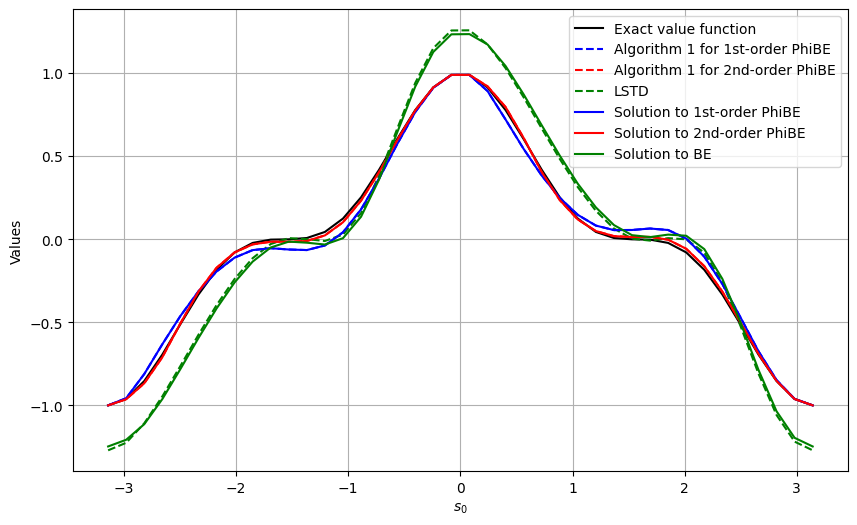

In [46]:
#plot together
plt.figure(figsize=(10, 6))

plt.plot(s_0_values, True_values, 'k-', label='Exact value function')  # 黑色实线
plt.plot(s_0_values, Galerkin_1st_values, 'b--', label='Algorithm 1 for 1st-order PhiBE')  # 蓝色虚线
plt.plot(s_0_values, Galerkin_2nd_values, 'r--', label='Algorithm 1 for 2nd-order PhiBE')  # 红色虚线
plt.plot(s_0_values, LSTD_values, 'g--', label='LSTD')  # 绿色虚线
plt.plot(s_0_values, PhiBE_1st_values, 'b-', label='Solution to 1st-order PhiBE')  # 蓝色实线
plt.plot(s_0_values, PhiBE_2nd_values, 'r-', label='Solution to 2nd-order PhiBE')  # 红色实线
plt.plot(s_0_values, BE_values, 'g-', label='Solution to BE')  # 绿色实线


plt.xlabel('$s_0$')
plt.ylabel('Values')


plt.legend()
plt.grid(True)
plt.show()